## Эксперименты к практическому заданию №2 по логистической регресии.

### Accuracy на каждой эпохе будет считаться на отложенной части тренировочной выборки (30 %). Причем внутри обучения ('best_weights' в history) будут сохраняться "лучшие веса" модели - веса, при которых была достигнута наилучшая точность на отложенной части, если  save_best_weights == True, а в противном случае - по ключу 'best_weights' будут лежать веса заключительной эпохи.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

#### Загрузка данных

In [2]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

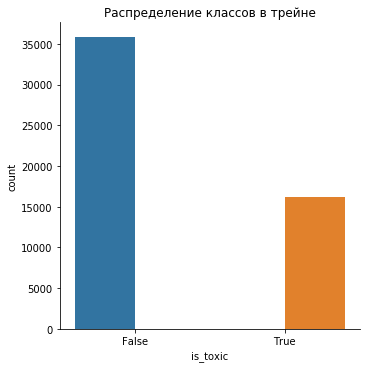

In [3]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [4]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

### 1. Приводим к нижнему регистру и заменяем все символы, не являющиеся буквами или цифрами на пробелы

In [5]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [6]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [7]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

### 2. Пользуемся CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
countVect = CountVectorizer(min_df=3e-6, lowercase=False)

In [9]:
train_data_processed_2 = countVect.fit_transform(train_data_processed_1)
test_data_processed_2 = countVect.transform(test_data_processed_1)

In [10]:
train_data_processed_2.shape[1]

91839

In [11]:
import optimization
import scipy

Add bias

In [12]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_2])
test_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_2])

In [13]:
%%time
def experiment_cycle(train_data, target,
                     step_alpha_list, step_beta_list,
                     w_0_list, batch_size_list, l2_coef=5e-5):
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
#                 print(step_alpha)
                clf = optimization.GDClassifier(step_alpha=step_alpha,
                                                step_beta=step_beta,
                                                experiment=True,
                                                l2_coef=l2_coef,
                                                max_iter=1500)
                yield clf.fit(train_data,
                                target,
                                w_0=w_0,
                                trace=True)
                
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
                for batch_size in batch_size_list:
                    clf = optimization.SGDClassifier(step_alpha=step_alpha,
                                                     step_beta=step_beta,
                                                     experiment=True,
                                                     max_iter=1500,
                                                     batch_size=batch_size, 
                                                     l2_coef=l2_coef)
                    yield clf.fit(train_data,
                                  target,
                                  w_0=w_0,
                                  trace=True, log_freq=0.1)
                    


CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 3.81 µs


In [14]:
train_data_processed_2.shape

(52061, 91839)

## ВАЖНО! Все эксперименты будут проводиться с добавлением смещения в веса, которое не будет учитываться в регуляризации (чтобы даже в том случае, когда регуляризация занулит почти все веса, наша разделяющая гиперплоскость не вырождалась в 0)

In [15]:
import tqdm
history_list = []
step_alpha_list = [0.001, 0.01, 0.1, 1, 5, 10, 50]
# step_alpha_list = [0.1]
step_beta_list = [0, 0.001, 0.01, 0.1, 1, 5, 10, 50]
batch_size_list = [1, 64, 128, 1024, 1024 * 4, 1024 * 10, 1024 * 20]
w_0_list = [None]
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [16]:
keys_for_df = ['time', 'func', 'accuracy']

In [17]:
len(history_list[0]['time']), len(history_list[0]['func']), len(history_list[0]['accuracy']),

(1501, 1501, 1501)

In [18]:
history_list[1]['classifier_type'], history_list[30]['step_alpha']

('GD', 1)

In [19]:
{key: history_list[300][key] for key in keys_for_df}

{'time': [0,
  0.41362810134887695,
  0.0059473514556884766,
  0.005877494812011719,
  0.0059413909912109375,
  0.005832195281982422,
  0.0059909820556640625,
  0.005923271179199219,
  0.0058879852294921875,
  0.005861759185791016,
  0.005864143371582031,
  0.005863189697265625,
  0.005959272384643555,
  0.005846500396728516,
  0.005953550338745117,
  0.00586700439453125,
  0.005940675735473633,
  0.00590062141418457,
  0.005211591720581055,
  0.0058917999267578125,
  0.004858732223510742,
  0.005307197570800781,
  0.0059545040130615234,
  0.0058286190032958984,
  0.0060384273529052734,
  0.005909442901611328,
  0.005918025970458984,
  0.005855083465576172,
  0.005929470062255859,
  0.005823850631713867,
  0.006012439727783203,
  0.005408048629760742,
  0.005896568298339844,
  0.0058329105377197266,
  0.006033420562744141,
  0.005944967269897461,
  0.0059163570404052734,
  0.00597834587097168,
  0.0059795379638671875,
  0.004984378814697266,
  0.005983829498291016,
  0.0058739185333251

In [20]:
hist_0_df = pd.DataFrame({key: history_list[29][key] for key in keys_for_df})
hist_1_df = pd.DataFrame({key: history_list[300][key] for key in keys_for_df})

[]

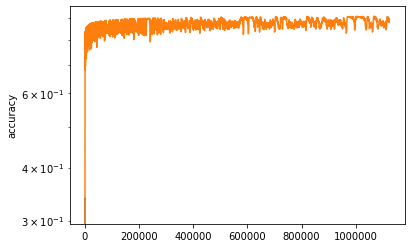

In [62]:
sns.lineplot(x = np.cumsum(np.arange(len(hist_0_df['accuracy']))), y=hist_0_df['accuracy'])
sns.lineplot(x = np.cumsum(np.arange(len(hist_1_df['accuracy']))), y=hist_1_df['accuracy'])
# plt.semilogy()

In [22]:
import pickle
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'wb') as f:
    pickle.dump(history_list, f)

## Эксперименты с различными начальными приближениями:
https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero
###   Рассмотрим 7 экспериментов: 
    1) w_0 = 0
    2) w_0 = uniform(0, 1)
    3) w_0 = uniform(100, 500)
    4) w_0 = uniform(1000, 5000)
    5) w_0 = uniform (10000, 50000)
    6) w_0 = normal with mean = 0, std = 1
    7) w_0 = normal with mean = 0.5, std = 0.5

In [23]:
w_0_list = []
w_0_list.append(np.zeros(train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]))

w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))

In [24]:
train_data_processed_2_with_bias.shape

(52061, 91840)

In [25]:
w_0_list[0].shape

(91840,)

###  Выберем лучшие параметры из прошлого эксперимента:

In [26]:
import pickle 
history_list = []
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [27]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [28]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0])

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1])

10 0.001 GD 0.9136308342403483
10 0 SGD 0.9149113259491645


In [29]:
import tqdm
step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [30]:
max(history_list[0]['accuracy']), max(history_list[-1]['accuracy'])

(0.9136308342403483, 0.9131186375568218)

In [31]:
import pickle
with open('GD_SGD_w_0_init.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [32]:
with open('GD_SGD_w_0_init.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [33]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [34]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 6)

10 0.001 GD 0.914399129265638 6
10 0.001 SGD 0.9138869325821115 1


In [35]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

In [37]:
train_data_processed_1

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159494        our previous conversation   you fucking sh...
159514                    you are a mischievious pubic hair
159541    your absurd edits   your absurd edits on great...
159546       hey listen don t you ever     delete my edi...
159554    and i m going to keep posting the stuff u dele...
Name: comment_text, Length: 52061, dtype: object

In [38]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])

CPU times: user 11.7 s, sys: 92 ms, total: 11.8 s
Wall time: 11.8 s


In [39]:
train_data_processed_lemmatized

0         [explanation, why, the, edits, made, under, my...
1         [d, aww, he, match, this, background, colour, ...
2         [hey, man, i, m, really, not, trying, to, edit...
3         [more, i, can, t, make, any, real, suggestion,...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159494    [our, previous, conversation, you, fucking, sh...
159514             [you, are, a, mischievious, pubic, hair]
159541    [your, absurd, edits, your, absurd, edits, on,...
159546    [hey, listen, don, t, you, ever, delete, my, e...
159554    [and, i, m, going, to, keep, posting, the, stu...
Name: comment_text, Length: 52061, dtype: object

In [40]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
%%time
# train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

# test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))

CPU times: user 88.5 ms, sys: 4 ms, total: 92.5 ms
Wall time: 92.3 ms


In [42]:
%%time
train_data_processed_3 = countVect.fit_transform(train_data_processed_3)
test_data_processed_3 = countVect.transform(test_data_processed_3)

CPU times: user 2.46 s, sys: 3.96 ms, total: 2.46 s
Wall time: 2.46 s


In [43]:
train_data_processed_3

<52061x85480 sparse matrix of type '<class 'numpy.int64'>'
	with 2072093 stored elements in Compressed Sparse Row format>

Add bias

In [44]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3])
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])

## Так как лучшими значениями для w_0 оказались:
    1) GD - w_0 = zeros
    2) SGD - w_0 = np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]), поэтому:

In [45]:
import tqdm
step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
w_0_list = []
# w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_3_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_3_with_bias.shape[1]))

# w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [46]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [47]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 1)

10 0.001 GD 0.9097253345284589 2
10 0.001 SGD 0.9161918176579806 2


In [48]:
import pickle
with open('GD_SGD_lemmatized.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [49]:
import pickle
with open('GD_SGD_lemmatized.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [50]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [51]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 1)

10 0.001 GD 0.9097253345284589 2
10 0.001 SGD 0.9161918176579806 2


## Эксперименты с min_df и max_df
Если мы рассматриваем 0 <= min_df <= 1; 0 <= max_df <= 1, то они связаны формулой: $min\_df + max\_df = 1$, поэтому будем исследовать значение параметра $min\_df$

In [52]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [1e-6, 2.5e-5, 5e-5, 7.5e-5,
               1e-4, 2.5e-4, 5e-4, 7.5e-4,
               1e-3, 2.5e-3, 5e-3, 7.5e-3]
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
history_list = []


for min_df in min_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
        train_data_processed_3 = train_data_processed_3.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3])
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
        w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['min_df'] = min_df
            history_list.append(history)
    
    


CPU times: user 35min 8s, sys: 35.7 s, total: 35min 43s
Wall time: 7min 25s


In [53]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [54]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [55]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [56]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      history_list[arg_max[0]]['min_df'],
      history_list[arg_max[0]]['preprocesser_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      history_list[arg_max[1]]['min_df'],
      history_list[arg_max[1]]['preprocesser_type'],
      max_acc[1],
      arg_max[1] - 1)

10 0.001 GD 1e-06 BOW 0.9109418016518344 1
10 0.001 SGD 2.5e-05 BOW 0.9108137524809526 9


###  Качество упало! Есть предположение, что удаление стоп слов - не самая лучшая идея в данной задаче, так как в них есть такие, как "aren't", "didn't", которые указывают на отрицание. Пример: you aren't nice -> you nice (после удаления стоп слов). Это плохо! Попробуем вернуть стопслова, оставив только лемматизацию и стемминг.

In [57]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [1e-6, 2.5e-5, 5e-5, 7.5e-5,
               1e-4, 2.5e-4, 5e-4, 7.5e-4,
               1e-3, 2.5e-3, 5e-3, 7.5e-3]
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
history_list = []


for min_df in min_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3])
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
        w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['min_df'] = min_df
            history_list.append(history)
    
    


CPU times: user 1h 8min 29s, sys: 1min 6s, total: 1h 9min 35s
Wall time: 14min 22s


In [58]:
import pickle
with open('GD_SGD_bow_tfid_min_df_with_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [59]:
import pickle
with open('GD_SGD_bow_tfid_min_df_with_stopwords.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [60]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [61]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      history_list[arg_max[0]]['min_df'],
      history_list[arg_max[0]]['preprocesser_type'],
      max_acc[0])

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      history_list[arg_max[1]]['min_df'],
      history_list[arg_max[1]]['preprocesser_type'],
      max_acc[1])

10 0.001 GD 0.00075 BOW 0.9145271784365196
10 0.001 SGD 1e-06 BOW 0.9172802356104744


In [63]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

### И действительно: качество стало лучше! 0.9173, а до этого было 0.9162.

 ### Заметим еще одну интересную особенность: CountVectorizer работает лучше, чем TF-IDF. Это может быть связано с тем, что TF-IDF сильно штрафует часто встречающиеся слова и отдает приоритет менее встречающимся. Опять же, учитывая специфику нашей задачи, 